In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

import pysindy as ps

In [2]:
import numpyro
numpyro.set_host_device_count(2)

In [3]:
np.random.seed(987)

In [4]:
class PredatorPreyModel:
    def __init__(self, a=1.0, b=0.3, c=0.2, d=1.0):

        self.a = a
        self.b = b
        self.c = c
        self.d = d

    def dydx(self, t, y):
        # Lotka-Volterra Model model, see e.g. https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations
        return np.array([self.a*y[0] - self.b*y[0]*y[1], self.c*y[0]*y[1] - self.d*y[1]])

    def solve(self, **kwargs):
        return solve_ivp(self.dydx, **kwargs)

In [5]:
my_model = PredatorPreyModel()

In [6]:
sol = my_model.solve(t_span=[0, 30], y0=np.array([10,5]), max_step=0.1)

In [7]:
noise = 0.1

t = sol.t
P = sol.y[0,:] + np.random.normal(scale=noise, size=sol.t.size)
Q = sol.y[1,:] + np.random.normal(scale=noise, size=sol.t.size)

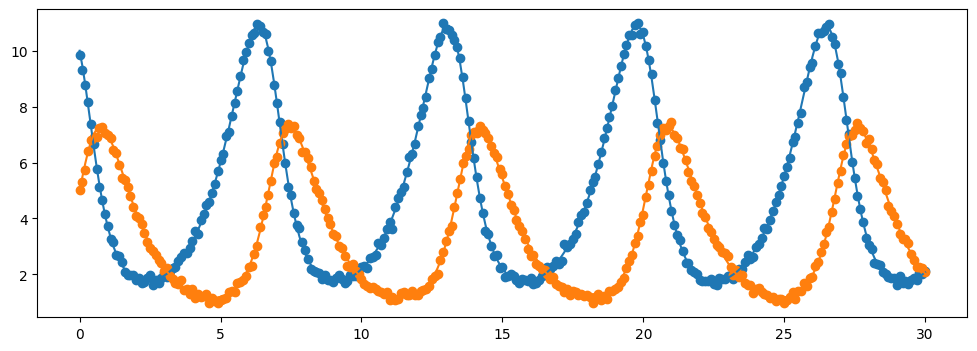

In [8]:
plt.figure(figsize=(12,4))

plt.plot(sol.t, sol.y[0,:])
plt.scatter(t, P)

plt.plot(sol.t, sol.y[1,:])
plt.scatter(t, Q)
plt.show()

In [9]:
optimizer = ps.optimizers.SBR(seed=123, num_warmup=500, num_samples=2000, num_chains=2)
feature_library = ps.feature_library.polynomial_library.PolynomialLibrary(include_interaction=True)
sindy = ps.SINDy(optimizer, feature_library, feature_names=['P', 'Q'])
sindy.fit(np.c_[P, Q], t=t)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['P', 'Q'],
      optimizer=SBR())

In [10]:
def surrogate_dydt(t, y):
    _y = y[np.newaxis,:]
    return sindy.predict(x=_y)

In [11]:
sol = solve_ivp(surrogate_dydt, t_span=[0, 30], y0=np.array([10,5]), max_step=0.1)

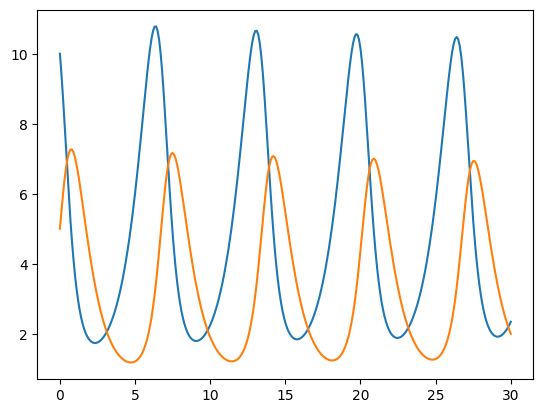

In [12]:
plt.plot(sol.t, sol.y.T)
plt.show()

In [13]:
import arviz as az

In [14]:
samples = az.from_numpyro(sindy.optimizer.mcmc)
az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0_0,0.020,0.115,-0.180,0.236,0.004,0.003,1142.0,1132.0,1.00
beta_0_1,0.986,0.048,0.894,1.075,0.001,0.001,1394.0,1288.0,1.00
beta_0_2,0.005,0.044,-0.075,0.087,0.001,0.001,1516.0,1633.0,1.00
beta_0_3,-0.001,0.005,-0.009,0.008,0.000,0.000,1408.0,1572.0,1.00
beta_0_4,-0.295,0.008,-0.310,-0.279,0.000,0.000,2204.0,2366.0,1.00
beta_0_5,-0.002,0.007,-0.018,0.010,0.000,0.000,1309.0,1579.0,1.00
beta_1_0,0.000,0.103,-0.202,0.208,0.003,0.003,1276.0,1125.0,1.01
beta_1_1,0.004,0.032,-0.058,0.068,0.001,0.001,1794.0,1420.0,1.00
beta_1_2,-1.018,0.065,-1.162,-0.909,0.002,0.001,1292.0,1085.0,1.00
beta_1_3,0.000,0.004,-0.007,0.007,0.000,0.000,1958.0,1657.0,1.00


[]

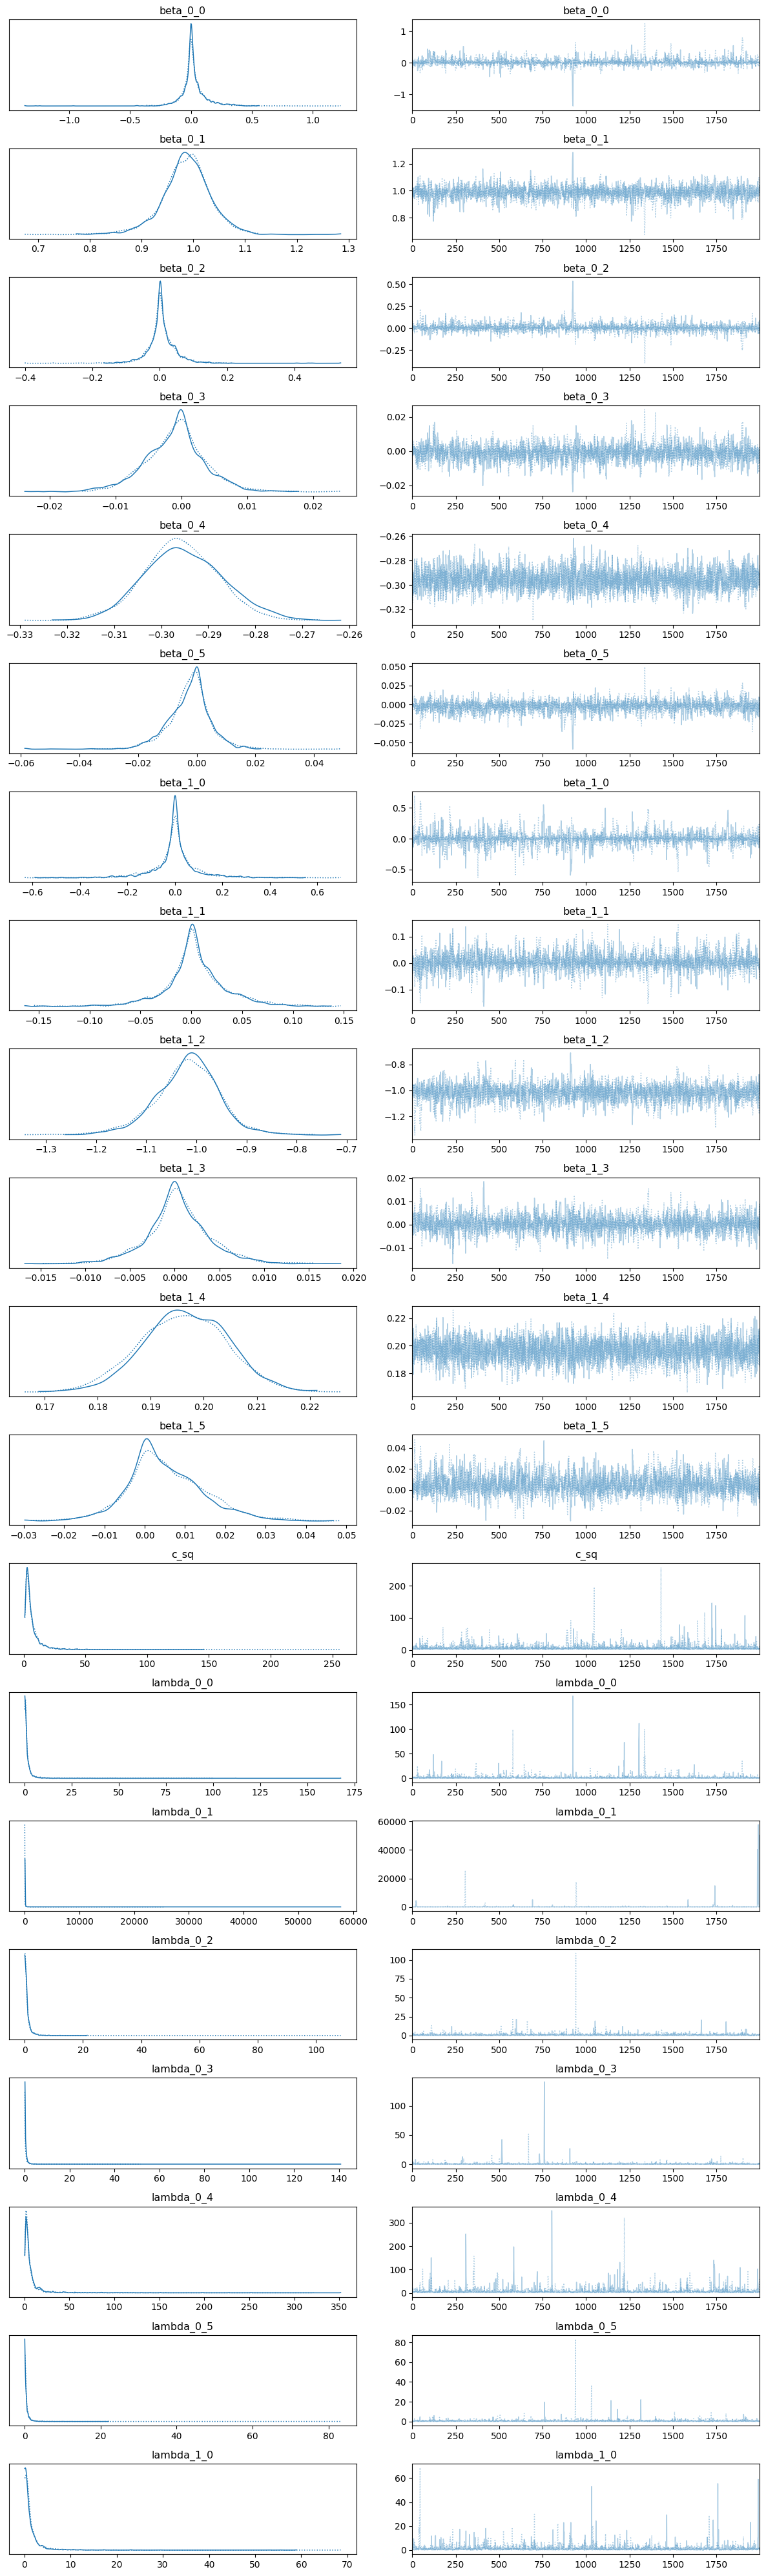

In [15]:
az.plot_trace(samples, divergences=False)
plt.tight_layout()
plt.plot()